In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import ast
from itertools import zip_longest

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# target = "Lehne"
target = "Delatorre"

In [ ]:
def get_zipped_average(lists):
    zipped_lists = zip_longest(*lists, fillvalue=None)
    averages = [
        sum(filter(None.__ne__, group)) / max(1, len(list(filter(None.__ne__, group))))
        for group in zipped_lists
    ]
    return averages

def get_llm_ratings(llm_rating_sources: list[str]) -> list[float]:
    """
    Get the average llm rating for a given source.
    Args:
        llm_rating_sources: list of llm rating sources. This is the dirname to start checking for csv files from.
                            Subdirectories will be checked starting from this directory.
    Return:
        List of all llm ratings for the given source.
        If multiple sources are given return the average rating across all sources.
    """
    all_source_ratings = []

    for source in llm_rating_sources:
        source = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"
        source_ratings = []
        
        # Traverse through the directory to find CSV files
        for root, _, files in os.walk(source):
            for file in files:
                if file.endswith(".csv"):
                    # Read the CSV file
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path)
                    
                    # Assuming the response column contains the dictionary of ratings as string
                    if 'response' in df.columns:
                        model_ratings = []
                        for response in df['response']:
                            response_dict = ast.literal_eval(response)
                            ratings = response_dict.values()
                            model_ratings.append(ratings)
                        source_ratings = get_zipped_average(model_ratings)
        
        if source_ratings:
            all_source_ratings.append(source_ratings)

    llm_ratings = get_zipped_average(all_source_ratings)
    return llm_ratings

def per_model_ratings(llm_rating_sources: list[str]) -> dict[str, list[float]]:
    """
    Get the llm ratings from all sources.
    Args:
        llm_rating_sources: list of llm rating sources. This is the dirname to start checking for csv files from.
                            Subdirectories will be checked starting from this directory.
    Return:
        Dict of all llm ratings from all sources.
        Keyed by model name to list of scores.
    """
    all_ratings = {}

    experiments = ["e1", "e2", "e3"]
    model_names = ['deepseek-ai_DeepSeek-V3', 'google_gemma-2-27b-it', 'google_gemma-2-9b-it', 'meta-llama_Llama-2-7b-chat-hf', 'meta-llama_Llama-3-70b-chat-hf', 'meta-llama_Llama-3-8b-chat-hf', 'microsoft_WizardLM-2-8x22B', 'mistralai_Mistral-7B-Instruct-v0.3', 'mistralai_Mixtral-8x7B-Instruct-v0.1', 'Qwen_Qwen2-72B-Instruct']
    shortened_model_names = ["DS-V3", "G-27B", "G-9B", 'L2-7B', 'L3-70B', 'L3-8B', 'W-22B', 'M-7B', 'Mx-7B', 'Q-72B']

    for source in llm_rating_sources:
        source = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"

        for experiment in experiments:
            for i, model in enumerate(model_names):
                csv_path = os.path.join(source, experiment, model)
                csv_path = os.path.join(csv_path, os.listdir(csv_path)[0], "results.csv")

                # Read the CSV file
                ratings = []
                df = pd.read_csv(csv_path)
                if 'response' in df.columns:
                    for response in df['response']:
                        response_dict = ast.literal_eval(response)
                        ratings = list(response_dict.values())

                shortened_model_name = shortened_model_names[i]
                if shortened_model_name not in all_ratings:
                    all_ratings[shortened_model_name] = []
                all_ratings[shortened_model_name].append(ratings)

    for shortened_model_name, ratings in all_ratings.items():
        all_ratings[shortened_model_name] = get_zipped_average(ratings)

    return all_ratings


In [ ]:
llm_rating_sources = None
if target == "Lehne":
    llm_rating_sources = ["lehne_experiment/final/"]
elif target == "Delatorre":
    llm_rating_sources = ["delatorre_experiment/final/"]

llm_ratings = get_llm_ratings(llm_rating_sources)
llm_ratings_by_model = per_model_ratings(llm_rating_sources)

In [ ]:
lehne = [5.565217391, 5, 4.826086957, 5.739130435, 5.52173913, 6.826086957, 7.304347826, 5.434782609, 6.391304348, 7.47826087, 7.043478261, 5.869565217, 6.739130435, 6.956521739, 6.47826087, 5.956521739, 4.652173913, 4.260869565, 5.173913043, 4.086956522, 4.173913043, 4.304347826, 5, 4.043478261, 4.217391304, 4.434782609, 5.347826087, 6.217391304, 5.434782609, 4.782608696, 6.173913043, 5.956521739, 6.47826087, 5, 4.739130435, 5.173913043, 6.304347826, 6.434782609, 5.260869565, 5.304347826, 5.956521739, 4.304347826, 5.260869565, 4.391304348, 4.956521739, 5.695652174, 5.043478261, 5.826086957, 5.043478261, 4.913043478, 5.217391304, 6.217391304, 6.391304348, 6.52173913, 7.217391304, 6.565217391, 5.52173913, 4.347826087, 3.869565217, 7, 7.565217391, 6.52173913, 6.260869565, 6.043478261, 4.913043478]

# bentz = [5.722806985294119, 11.05916240409207, 10.176644957983195, 7.114928792569659, 6.099157439446366, 5.566299307958478, 17.45514241486068, 20.56654953560372, 14.074101604278075, 11.005892857142857, 10.182784926470589, 13.225643598615918, 15.510902476780188, 17.722190311418682, 17.559285294117643, 16.105406862745095, 14.799439705882353, 13.646433006535949, 13.32528431372549, 17.817691950464397, 19.465673010380623, 19.729349845201238, 17.95638080495356, 16.52333281733746, 15.829901960784314, 14.44470751633987, 11.858982352941178, 12.473614705882353, 13.266633126934982, 12.13799705882353, 11.304029411764708, 10.899100346020763, 11.029245098039217, 12.146807189542484, 12.750317647058825, 12.54380735294118, 13.642642647058825, 14.732547058823531, 16.67970261437908, 15.694006047873696, 15.648868512110726, 15.350144117647059, 15.374905882352943, 14.648437908496735, 12.62051797385621, 10.956928104575162, 9.631577030812325, 9.692333910034604, 8.245710784313728, 9.478299051857585, 12.43716563467492, 12.374813725490196, 12.402410130718955, 14.686942810457518, 15.052090073529412, 14.634486068111453, 18.123255882352943, 19.497089783281734, 19.749135294117647, 20.792210784313724, 21.082425696594427, 19.15788235294118, 18.07518137254902, 18.323945187165776, 19.19976989619377, 16.961331699346406, 14.677286377708977, 13.684705882352944, 15.826565015479877, 19.672383986928104, 21.969750865051907, 23.30329411764706, 24.561427601809957, 24.233156346749222, 24.545139705882352, 26.391583591331266, 26.473653594771243, 25.7525, 28.182441176470586, 30.907944444444443, 31.042676470588233, 29.05366666666667, 27.47116176470588, 26.843221227621484, 25.45178947368421, 24.945612299465243, 26.672071428571428, 26.546444272445818, 24.512742647058825, 24.267127450980393, 27.192478991596637, 33.16186425339367, 32.094166666666666, 29.6981, 28.632405462184874, 27.773249999999997, 26.992778546712803, 24.78235294117647, 23.85904411764706, 23.71569040247678, 24.106462848297216, 22.55586061381074, 22.374941176470585, 21.841009803921565, 20.480698529411768, 17.6074446366782, 14.44325541795666, 12.524396284829722, 11.880472549019608, 15.512207282913167, 20.616085139318887, 20.464073529411767, 21.093086687306506, 20.856195187165778, 17.839051470588235, 16.535029411764707, 15.656599439775912, 16.932544117647055, 22.179710294117648, 21.456007352941175, 20.117741830065363, 19.28415294117647, 18.910838235294122, 18.918298319327732, 17.779165266106443, 17.466493464052295, 19.231535294117645, 22.93496323529412, 26.49512254901961, 27.205697058823525, 30.007072192513373, 28.393787925696596, 26.85357352941176, 28.249730392156863, 27.244920168067228, 27.338547794117645, 26.54530588235294, 24.899828173374612, 22.83691176470588, 20.77564985994398, 20.51521568627451, 19.062049019607837, 16.592596638655465, 18.275367647058825, 27.905075, 29.334514705882352, 25.093589572192517, 19.447133126934983, 16.447647058823527, 19.058363636363637, 24.388437908496734, 26.278242647058825, 25.534026960784313, 29.21232549019608, 29.795710084033615, 24.86472910216718, 22.863725490196078, 20.7369692513369, 19.076182352941174, 18.517647058823528, 17.6023487394958, 14.94836111111111, 13.438740896358544, 16.105606209150327, 18.319954248366013, 18.078679411764707, 17.664794117647062, 17.06517513368984, 16.485388544891638, 14.427848755441453, 13.576512110726641, 12.017716176470588, 11.879204044117648, 12.809175, 17.503256535947713, 17.75494537815126, 18.65083823529412, 16.02368464052288, 14.073091176470587, 13.904702205882352, 13.971928571428572, 12.923748663101604, 12.225941176470588, 12.662591911764704, 12.602894117647057, 12.4060318627451, 12.417464985994396, 14.151664705882357, 16.339893557422972, 17.893362745098038, 19.200911764705882, 19.12337843137255, 17.371677941176475, 16.607595588235295, 17.630668730650154, 18.307455882352944, 18.467377941176473, 18.9919068627451, 20.069433823529412, 21.336068111455113, 22.731417956656344, 22.903745989304813, 21.71013088235294, 22.42164705882353, 23.16619117647059, 23.875465944272445, 24.320976890756302, 24.03204248366013, 26.109693771626297, 26.222119117647054, 25.410250700280113, 24.074558823529408, 24.078991176470588, 23.25504347826087, 21.991056722689073, 21.338450980392153, 20.9964375, 20.335875, 20.66961764705882, 23.344540106951875, 26.51085294117647, 26.013720588235294, 24.250387543252593, 21.990600840336132, 23.025572829131654, 25.236897058823526, 26.32927124183006, 26.120114186851215, 26.55146323529412, 26.839447058823527, 26.900848739495792, 26.29785294117647, 26.07654411764706, 26.037251633986934, 26.898101604278075, 33.81381833910035, 48.40757266435986, 53.42682843137255, 50.233819852941174, 51.924921568627454, 56.08438235294117, 59.119974789915965, 64.23566099071206, 75.36540896358544, 80.959, 85.98692794117648, 95.3404986631016, 100.96856617647059, 104.29738235294117, 107.63588051470587, 105.21067647058825, 102.231022875817, 103.0474814241486, 101.73784191176472, 102.93723529411764, 109.76126470588235, 105.01897181372549, 100.85559861591695, 98.2981950464396, 95.37922029456944, 88.44012383900929, 91.06242112299464, 97.15785139318886, 101.01073529411764, 100.60330555555554, 100.73289792387541, 96.95793252595156, 95.07487794117648, 94.74019117647059, 90.16191470588237, 80.02010147058823, 73.68095674740485, 67.8421388888889, 62.97488368983957, 61.147489164086686, 58.41641176470589, 56.10203460207612, 56.42993417366946, 54.690753869969036, 51.81656029411764, 55.88604024767801, 60.369505882352954, 63.258568181818184, 65.71950865051903, 69.30895847750865, 70.19432352941178, 68.85285166240409, 64.15298970588236, 60.50676315789474, 58.44099999999999, 57.931379256965954, 57.87941978609624, 57.260163235294115, 57.892364450127864, 64.26010084033614, 75.93474369747899, 79.10853970588235, 79.84661764705884, 80.14906699346403, 78.73512659846547, 80.78884852941178, 82.58434313725489, 77.31641176470586, 74.37791560102302, 69.61072727272726, 68.00538235294118, 68.49562834224598, 64.78805263157895, 65.41110681114553, 69.15733545539427, 71.53683823529411, 74.32562464985995, 75.17658403361345, 73.41823262032086, 70.05329901960782, 68.92875882352942, 65.90874264705883, 64.39923839009286, 64.80960947712418, 65.26220772058822, 65.31959442724458, 63.767246498599434, 63.6881544117647, 63.17291176470589, 63.206561764705896, 64.11639619377162, 66.3888161764706, 68.17158996539793, 66.71792647058822, 67.15861601307189, 69.07404144385026, 70.47444999999999, 75.52585154061623, 80.42727287581698, 83.9655795847751, 90.30962605042016, 96.34309967320263, 98.82436580882356, 98.93075386996904, 105.83735588235295, 117.33584313725491, 115.10439100346024, 110.06833823529412, 109.99914086687306, 112.26201038062285, 113.28615641711234, 119.9344792387543, 130.197075, 138.93484803921567, 160.56501764705882, 175.16024117647058, 177.82488088235294, 173.9028010380623, 172.35485994397757, 173.41732085561495, 174.48921148459382, 174.8938786764706, 177.56210620915033, 179.8769820261438, 186.9069598930481, 190.00573262032086, 187.5332771493213, 190.80463840830453, 191.67416470588233, 187.11683753501399, 184.9210089514066, 188.39724732620323, 191.07466830065357, 185.84813647058826, 185.2796047873695, 184.24081764705883, 178.19064901960786, 171.65868088235297, 166.3054607843137, 156.8334117647059, 149.46710695187167, 141.0820544117647, 132.4475277777778, 133.4323511029412, 137.71560934421615, 136.36293088235294, 132.74120728291317, 129.13788502673793, 128.90934313725492, 129.3448382352941, 124.2884814241486, 124.98641176470588, 127.4297149321267, 132.95456470588235, 143.21540660474716, 151.37776890756302, 157.96819362745103, 165.58177030812325, 181.4628273657289, 189.25946439628478, 190.46434117647058, 176.1628431372549, 150.24279721362228, 132.26847549019607, 121.65475605536331, 110.69548452012384, 100.93981764705885, 93.22973684210525, 86.00066408668731, 80.4442614379085, 75.58584256055366, 67.52603267973858, 61.81637925696595, 61.09287955182073, 61.245064616755805, 61.05702941176471, 61.013605882352934, 63.42195220588236, 64.37568797953965, 66.15234593837535, 67.92524019607843, 67.50347794117648, 68.59144537815125, 69.4542463235294, 69.21378208556149, 71.80952941176471, 67.92987955182072, 61.98466106442578, 52.874304812834225, 42.26799845201239, 43.57794117647059, 39.6671568627451, 39.98655882352941, 42.754394957983195, 49.93342647058824, 49.57645098039216, 45.58964999999999, 48.392751633986926, 50.793138235294116, 52.714708439897684, 52.38061764705883, 51.60355882352942, 50.22640712074303, 49.45389635854341, 52.57689366515837]

delatorre = [3.34, 3.725, 3.705, 3.89, 4.08, 5.02, 4.87, 4.81, 5.84, 5.77, 6.44, 4.685]

In [ ]:
human_ratings = None
if target == "Lehne":
    human_ratings = lehne
elif target == "Delatorre":
    human_ratings = delatorre

In [ ]:
figsize = None
fontsize = None
if target == "Lehne":
    figsize = (40, 11)
    fontsize = 23
elif target == "Delatorre":
    figsize = (16, 11)
    fontsize = 14

In [ ]:
# plt.plot(llm_ratings, label='LLM Ratings')
# plt.plot(human_ratings, label='Human Ratings')

# plt.title('LLM vs Human Suspense Ratings')
# plt.xlabel('Passage')
# plt.ylabel('Suspense Rating')
# plt.legend()

# plt.show()

In [ ]:
# llm_ratings_norm = (np.array(llm_ratings) - np.min(llm_ratings)) / (np.max(llm_ratings) - np.min(llm_ratings))
# human_ratings_norm = (np.array(human_ratings) - np.min(human_ratings)) / (np.max(human_ratings) - np.min(human_ratings))
# plt.plot(llm_ratings_norm, label='LLM Ratings Normalized')
# plt.plot(human_ratings_norm, label='Human Ratings Normalized')

# plt.title('Normalized LLM vs Human Suspense Ratings')
# plt.xlabel('Passage')
# plt.ylabel('Suspense Rating')
# plt.legend()
    
# plt.show()

In [ ]:
# llm_ratings_diff = np.diff(llm_ratings)
# human_ratings_diff = np.diff(human_ratings)
# plt.plot(llm_ratings_diff, label='LLM Ratings Diff')
# plt.plot(human_ratings_diff, label='Human Ratings Diff')

# plt.title('LLM vs Human Suspense Ratings Diff')
# plt.xlabel('Passage')
# plt.ylabel('Suspense Rating')
# plt.legend()

# plt.show()

In [ ]:
model_names = list(llm_ratings_by_model.keys())
llm_ratings = np.array(list(llm_ratings_by_model.values()) + [human_ratings])

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings - human_ratings))
agreement_matrix = 1 - (np.abs(llm_ratings - human_ratings) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=figsize)

# Non-Gerrig
ax = sns.heatmap(agreement_matrix, annot=llm_ratings, cmap="viridis", cbar=True, linewidths=0, xticklabels=range(1, llm_ratings.shape[1] + 1), yticklabels=model_names + ["H"])

# Gerrig
# ax = sns.heatmap(agreement_matrix, annot=llm_ratings, cmap="coolwarm_r", cbar=True, linewidths=0.5, xticklabels=["Experiment A,Pen Mentioned Not Removed", "Experiment A,Pen Mentioned Removed", "Experiment A,Pen Not Mentioned", "Experiment B,Unused Comb", "Experiment B,Used Comb", "Experiment C,Prior Solution Mentioned and Removed", "Experiment C,Prior Solution Mentioned Not Removed", "Experiment C,Prior Solution Not Mentioned"], yticklabels=model_names + ["Human"])

plt.title(f"{target} Average Ratings by Model (1 = Agreement, 0 = Disagreement)", fontsize=fontsize)
plt.xlabel("Passage", fontsize=fontsize)
plt.ylabel("Models", fontsize=fontsize)
plt.show()

In [ ]:
def fmt_func(value):
    return f"+{value:.1f}" if value >= 0 else f"{value:.1f}"

model_names = list(llm_ratings_by_model.keys())
llm_ratings = np.array(list(llm_ratings_by_model.values()) + [human_ratings])

llm_ratings_change = np.diff(llm_ratings)
human_ratings_change = np.diff(human_ratings)

annot_fmt = np.vectorize(fmt_func)(llm_ratings_change)

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings_change - human_ratings_change))
agreement_matrix = 1 - (np.abs(llm_ratings_change - human_ratings_change) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=figsize)
ax = sns.heatmap(agreement_matrix, annot=annot_fmt, cmap="viridis", cbar=True, linewidths=0.0, xticklabels=range(2, llm_ratings_change.shape[1] + 2), yticklabels=model_names + ["H"], fmt="")

plt.title(f"{target} Average Ratings Change by Model (1 = Agreement, 0 = Disagreement)", fontsize=fontsize)
plt.xlabel("Passage", fontsize=fontsize)
plt.ylabel("Models", fontsize=fontsize)
plt.show()

In [ ]:
model_names = list(llm_ratings_by_model.keys())
llm_ratings = np.array(list(llm_ratings_by_model.values()) + [human_ratings])

llm_ratings_change = np.diff(llm_ratings)
human_ratings_change = np.diff(human_ratings)

llm_ratings_change_direction = np.where(llm_ratings_change > 0, 1, np.where(llm_ratings_change < 0, -1, llm_ratings_change))
human_ratings_change_direction = np.where(human_ratings_change > 0, 1, np.where(human_ratings_change < 0, -1, human_ratings_change))

# Compute agreement matrix (1 for agreement, 0 for disagreement)
max_diff = np.max(np.abs(llm_ratings_change_direction - human_ratings_change_direction))
agreement_matrix = 1 - (np.abs(llm_ratings_change_direction - human_ratings_change_direction) / max_diff)  # Normalize between 0 and 1

# Create a heatmap
plt.figure(figsize=figsize)
ax = sns.heatmap(agreement_matrix, annot=llm_ratings_change_direction, cmap="viridis", cbar=True, linewidths=0.0, xticklabels=range(2, llm_ratings_change_direction.shape[1] + 2), yticklabels=model_names + ["H"])

plt.title(f"{target} Average Ratings Change Direction by Model (1 = Agreement, 0 = Disagreement)", fontsize=fontsize)
plt.xlabel("Passage", fontsize=fontsize)
plt.ylabel("Models", fontsize=fontsize)
plt.show()

In [2]:
%pip install pandas matplotlib numpy
%pip install numpy

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 29.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 31.2 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 32.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# BREWER VIZ

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import os
import pandas as pd
import json
from collections import defaultdict
human_ratings = {
    'Story': ['American Story Old Phoebe', 'American Story Birthday', 'American Story Flying', 'American Story Lottery', 'American Story Ylla'],
    'Suspense': [3.4, 3.2, 3.6, 4.5, 5.1],

}

def get_llm_ratings(llm_rating_sources: list[str]) -> dict[str, dict[str, list[float]]]:
    llm_ratings = defaultdict(lambda: defaultdict(list))  

    for source in llm_rating_sources:
        source_path = f"{os.path.dirname(os.path.abspath(os.getcwd()))}/../outputs/{source}"
        
        for root, _, files in os.walk(source_path):
            model_name = os.path.basename(os.path.dirname(root))
            
            for file in files:
                if file.endswith(".csv"):
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path, header=None, names=['experiment_name', 'version', 'response'])

                    for _, row in df.iterrows():
                        if 'Chunks' in row['version']:
                            story_name = row['version'].split(' Chunks')[0]
                            response = row["response"]
                            
                            try:
                                response_dict = json.loads(response.replace("'", "\""))
                            except json.JSONDecodeError:
                                try:
                                    response_dict = ast.literal_eval(response)
                                except (ValueError, SyntaxError):
                                    print(f"Skipping malformed response: {response}")
                                    continue  

                            selected_values = [response_dict.get(str(key)) for key in ['0', '3', '6', '9', '12']]
                            selected_values = [v for v in selected_values if v is not None]


                            if selected_values:
                                llm_ratings[model_name][story_name] = selected_values


    return llm_ratings

from collections import defaultdict
def average_ratings_across_sources(*llm_rating_sources):
    averaged_data = defaultdict(lambda: defaultdict(list))
    
    for source in llm_rating_sources:
        llm_ratings = get_llm_ratings(source)
        
        for model, stories in llm_ratings.items():
            for story, ratings_list in stories.items():
                if story not in averaged_data[model]:
                    averaged_data[model][story] = []
                
                averaged_data[model][story].append(ratings_list)
    
    for model, stories in averaged_data.items():
        for story, ratings_lists in stories.items():
            averaged_ratings = [
                sum(ratings) / len(ratings) for ratings in zip(*ratings_lists)
            ]
            averaged_data[model][story] = [round(rating, 2) for rating in averaged_ratings]
    
    return averaged_data

llm_rating_sources1 = ['brewer_experiment/final/paper/exp1']
llm_rating_sources2 = ['brewer_experiment/final/paper/exp2']
llm_rating_sources3 = ['brewer_experiment/final/paper/exp3']

averaged_llm_ratings = average_ratings_across_sources(llm_rating_sources1, llm_rating_sources2, llm_rating_sources3)

print(averaged_llm_ratings)

story_llm_ratings = defaultdict(lambda: defaultdict(list))

for llm, stories in averaged_llm_ratings.items():
    for story, ratings in stories.items():
        story_llm_ratings[story][llm] = ratings

story_llm_ratings = dict(story_llm_ratings)

print(story_llm_ratings)

stepwise_story_averages = {}

for story, llm_ratings in story_llm_ratings.items():
    step_ratings = defaultdict(list)

    for llm, ratings in llm_ratings.items():
        for i, rating in enumerate(ratings):
            step_ratings[i].append(rating)

    step_means = []
    max_step = max(step_ratings.keys()) 
    for i in range(max_step + 1):
        if step_ratings[i]:
            step_means.append(np.mean(step_ratings[i]))
        else:
            step_means.append(None)

    stepwise_story_averages[story] = step_means
print(stepwise_story_averages)


Skipping malformed response: { '0': 1, '1': 2, '2': 1, '3': 1, '4': 4, '5': 1, '6': None, '7': None, '8': None,  # Error - No Response '9': 1, '10': 2, '11': 1, '12': 3, '13': 4, '14': 3 }
defaultdict(<function average_ratings_across_sources.<locals>.<lambda> at 0x1045628c0>, {'mistralai_Mixtral-8x7B-Instruct-v0.1': defaultdict(<class 'list'>, {'American Story Old Phoebe': [4.0, 4.0, 4.0], 'American Story Ylla': [3.0, 5.0, 3.0, 3.0], 'American Story Flying': [5.0, 3.0, 5.0, 4.0, 2.0], 'American Story Birthday': [2.0, 3.0, 4.0, 1.0, 1.0], 'American Story Lottery': [1.0, 5.0]}), 'meta-llama_Llama-3-70b-chat-hf': defaultdict(<class 'list'>, {'American Story Old Phoebe': [1.0, 2.0, 2.0, 3.0, 5.0], 'American Story Lottery': [2.0, 3.0, 4.0, 5.0, 6.0], 'American Story Ylla': [6.0, 5.0, 6.0, 6.0, 6.0], 'American Story Flying': [1.0, 5.0, 6.0, 7.0, 1.0], 'American Story Birthday': [4.0, 3.0, 5.0, 4.0, 3.0]}), 'google_gemma-2-27b-it': defaultdict(<class 'list'>, {'American Story Old Phoebe': [3.

In [5]:
%pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


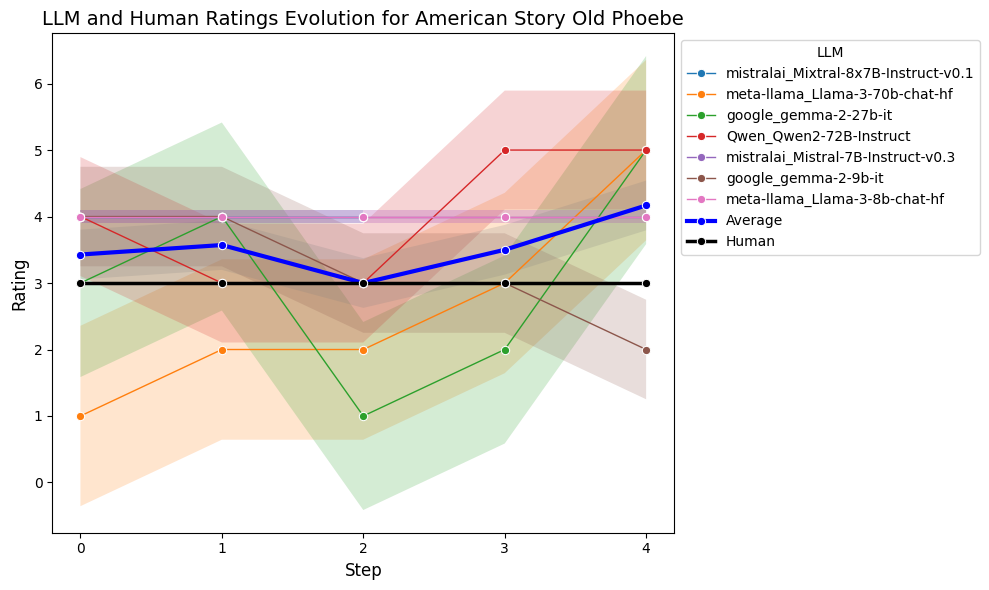

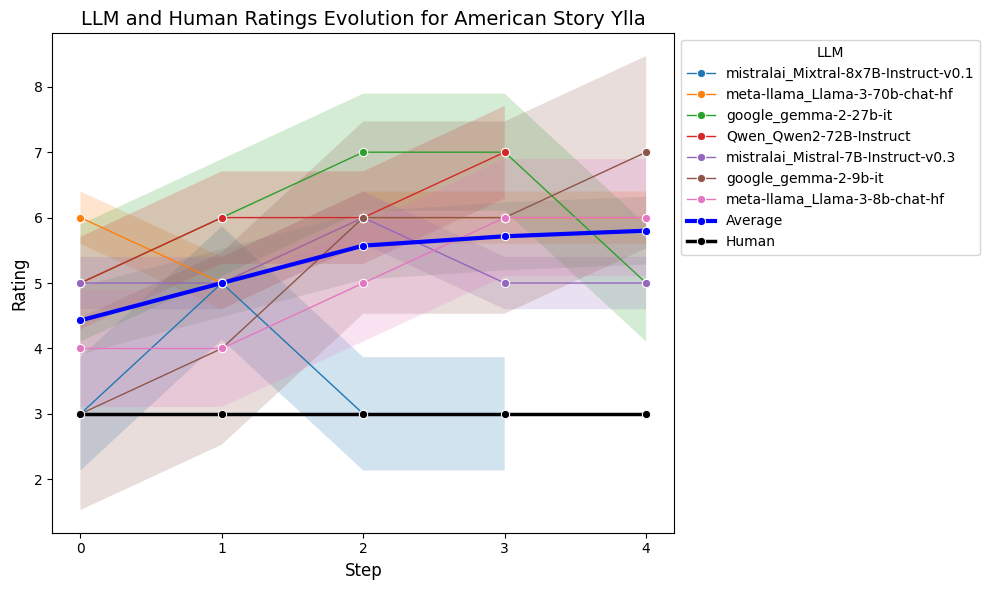

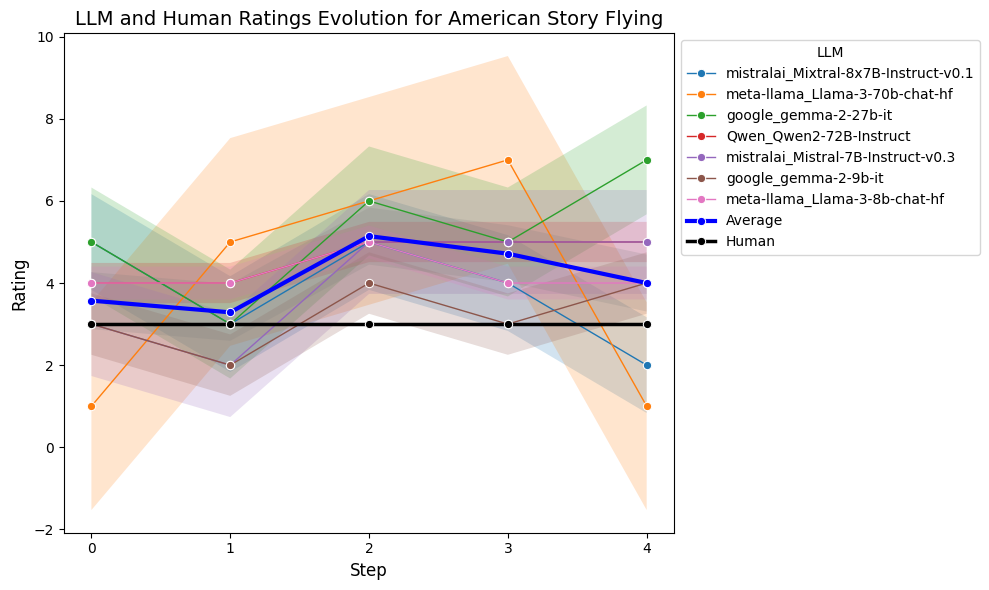

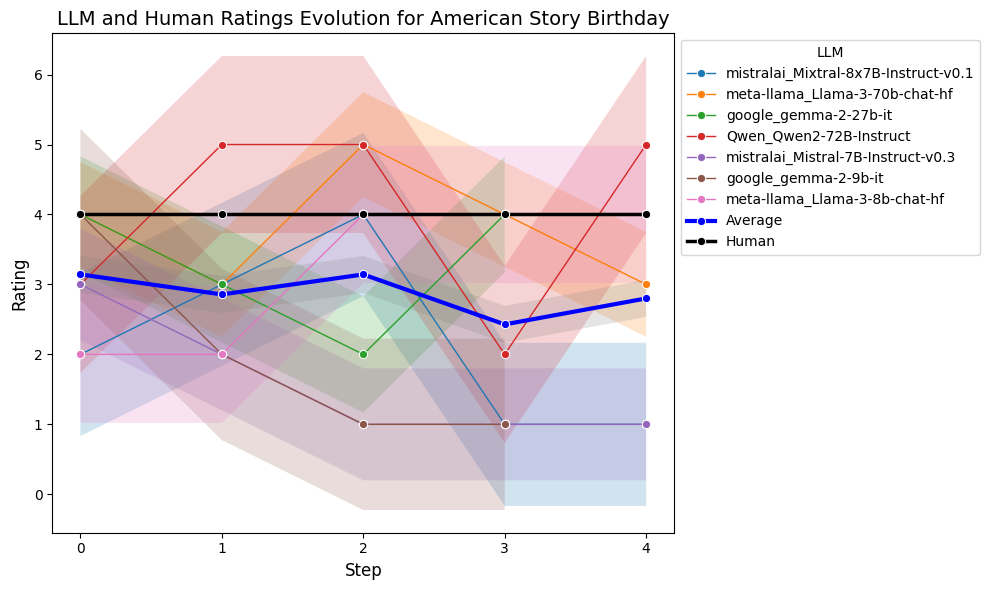

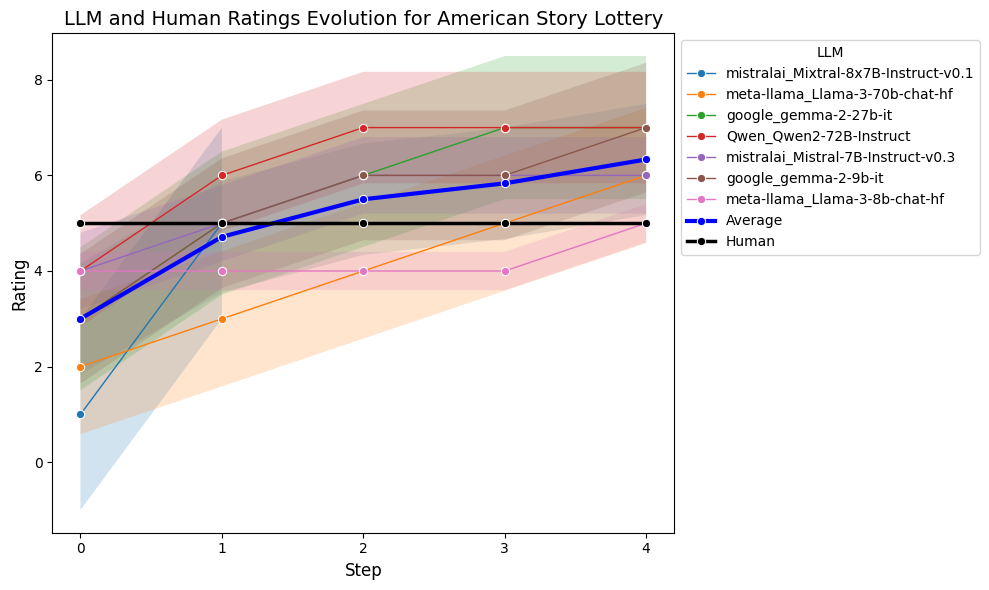

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

human_ratings = [3.4, 3.2, 3.6, 4.5, 5.1]  

for idx, (story, llm_data) in enumerate(story_llm_ratings.items()):
    plt.figure(figsize=(10, 6))
    for llm, ratings in llm_data.items():
        steps = np.array(range(len(ratings)))
        mean_ratings = np.array(ratings)
        std_dev = np.std(mean_ratings)
        min_ci = 0.1
        lower_bound = mean_ratings - np.maximum(std_dev, min_ci)
        upper_bound = mean_ratings + np.maximum(std_dev, min_ci)
        plt.fill_between(steps, lower_bound, upper_bound, alpha=0.2)
        sns.lineplot(x=steps, y=mean_ratings, label=llm, marker="o", linewidth=1)
    steps2 = np.array(range(len(ratings)))
    mean_ratings2 = np.array(stepwise_story_averages[story])
    std_dev2 = np.std(mean_ratings2)
    min_ci2 = 0.1
    lower_bound2 = mean_ratings2 - np.maximum(std_dev2, min_ci2)
    upper_bound2 = mean_ratings2 + np.maximum(std_dev2, min_ci2)
    plt.fill_between(steps2, lower_bound2, upper_bound2, alpha=0.2)
    sns.lineplot(x=steps2, y=mean_ratings2, label="Average", marker="o", linewidth=3,color = 'blue')
    human_steps = np.array(range(5))
    human_mean = np.full_like(human_steps, human_ratings[idx])
    sns.lineplot(
        x=human_steps, 
        y=human_mean, 
        label="Human", 
        marker="o", 
        linewidth=2.5, 
        color="black"
    )
    plt.title(f'LLM and Human Ratings Evolution for {story}', fontsize=14)
    plt.xlabel('Step', fontsize=12)
    plt.ylabel('Rating', fontsize=12)
    plt.legend(title='LLM', loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(sorted(steps))  
    plt.tight_layout()
    plt.show()
